In [2]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [3]:
variables = ["phyc", "temperature", "salinity", "o2", "no3", "po4"]

dict_vars = {}
for var in variables:
    print(f"Processing variable: {var}")
    filename = "ctd.nc" if var in ["temperature", "salinity"] else "ctd_bgc.nc"
    grp_dirs = sorted(
        glob.glob(os.path.expanduser(f"../data/GROUP*/results/{filename}"))
    )

    var_values = []
    times = []

    tmp = {}
    for nc_path in grp_dirs:
        ds = xr.open_dataset(nc_path).isel(obs=0)  # surface only

        # extract variable values and time
        var_values.append(ds[var].values.flatten())
        times.append(ds["time"].values[0])

    # organise to dict
    tmp["values"], tmp["time"] = var_values, times

    # master dict
    dict_vars[var] = tmp

plot_dict = {
    "phyc": {
        "label": "Phytoplankton",
        "units": "mmol m$^{-3}$",
        "color": "forestgreen",
    },
    "temperature": {
        "label": "Temperature",
        "units": "°C",
        "color": "crimson",
    },
    "salinity": {
        "label": "Salinity",
        "units": "PSU",
        "color": "lightseagreen",
    },
    "o2": {
        "label": "Oxygen",
        "units": "mmol m$^{-3}$",
        "color": "dodgerblue",
    },
    "no3": {
        "label": "Nitrate",
        "units": "mmol m$^{-3}$",
        "color": "darkorchid",
    },
    "po4": {
        "label": "Phosphate",
        "units": "mmol m$^{-3}$",
        "color": "coral",
    },
}


combined_vars = [v for v in variables if v not in ["no3", "po4"]] + ["no3_po4"]


Processing variable: phyc
Processing variable: temperature
Processing variable: salinity
Processing variable: o2
Processing variable: no3
Processing variable: po4


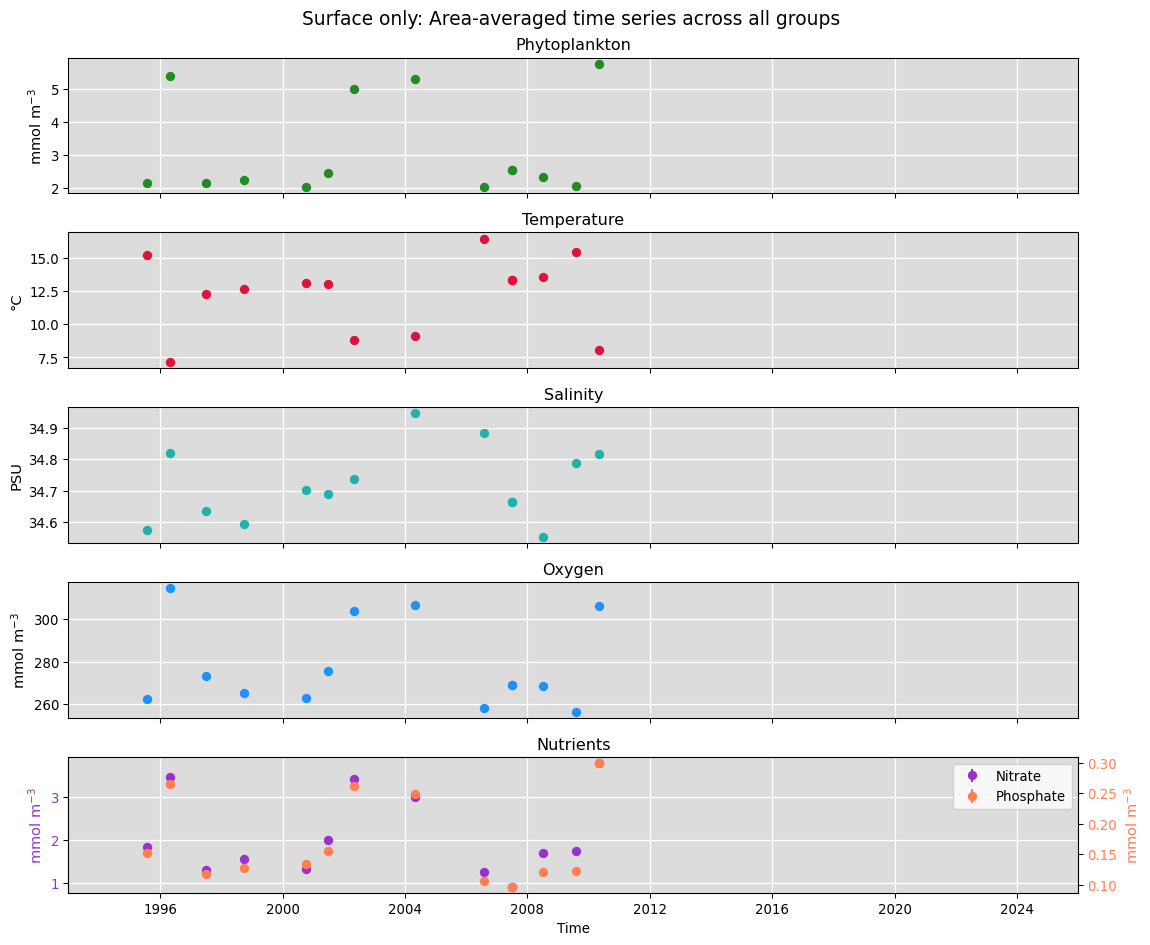

In [ ]:
# configs
LINES = False
VARIABILITY = False
MARKERSIZE = 6

fig, axs = plt.subplots(
    len(combined_vars), 1, figsize=(12, 10), dpi=96, sharex=True, sharey=False
)

for i, ax in enumerate(axs):
    if i < len(combined_vars) - 1:
        var = combined_vars[i]
        color = plot_dict[var]["color"]

        times = dict_vars[var]["time"]
        data = [np.nanmean(values) for values in dict_vars[var]["values"]]
        stds = [np.nanstd(values) for values in dict_vars[var]["values"]]

        # Sort all arrays by times
        sort_idx = np.argsort(times)
        times = np.array(times)[sort_idx]
        data = np.array(data)[sort_idx]
        stds = np.array(stds)[sort_idx]

        ax.errorbar(
            times,
            data,
            yerr=stds if VARIABILITY else 0.0,
            color=color,
            fmt="o",
            markersize=MARKERSIZE,
        )

        if LINES:
            ax.plot(
                times,
                data,
                linestyle="dotted",
                alpha=1.0,
                color=color,
                lw=2.25,
            )

        ax.set_title(f"{plot_dict[var]['label']}", fontsize=12)
        ax.set_ylabel(plot_dict[var]["units"], fontsize=11)
    else:
        color_no3 = plot_dict["no3"]["color"]
        color_po4 = plot_dict["po4"]["color"]

        no3_data = [np.nanmean(values) for values in dict_vars["no3"]["values"]]
        po4_data = [np.nanmean(values) for values in dict_vars["po4"]["values"]]
        no3_stds = [np.nanstd(values) for values in dict_vars["no3"]["values"]]
        po4_stds = [np.nanstd(values) for values in dict_vars["po4"]["values"]]
        # Sort by times
        no3_data = np.array(no3_data)[sort_idx]
        po4_data = np.array(po4_data)[sort_idx]
        no3_stds = np.array(no3_stds)[sort_idx]
        po4_stds = np.array(po4_stds)[sort_idx]

        ax.errorbar(
            times,
            no3_data,
            yerr=no3_stds if VARIABILITY else 0.0,
            color=color_no3,
            fmt="o",
            markersize=MARKERSIZE,
            label=plot_dict["no3"]["label"],
        )

        if LINES:
            ax.plot(
                times,
                no3_data,
                linestyle="dotted",
                alpha=1.0,
                color=color_no3,
                lw=2.25,
            )

        ax.set_ylabel(plot_dict["no3"]["units"], fontsize=11, color=color_no3)
        ax.tick_params(axis="y", labelcolor=color_no3)

        ax2 = ax.twinx()
        ax2.errorbar(
            times,
            po4_data,
            yerr=po4_stds if VARIABILITY else 0.0,
            color=color_po4,
            fmt="o",
            markersize=MARKERSIZE,
            label=plot_dict["po4"]["label"],
        )

        if LINES:
            ax2.plot(
                times,
                po4_data,
                linestyle="dotted",
                alpha=1.0,
                color=color_po4,
                lw=2.25,
            )

        ax2.set_ylabel(plot_dict["po4"]["units"], fontsize=11, color=color_po4)
        ax2.tick_params(axis="y", labelcolor=color_po4)

        ax.set_title("Nutrients", fontsize=12)

        handles, labels = [], []
        for a in [ax, ax2]:
            h, l = a.get_legend_handles_labels()
            handles += h
            labels += l
        ax.legend(handles, labels, loc="upper right")

    ax.set_xlim(np.datetime64("1993-01-01"), np.datetime64("2025-12-31"))

    if i == len(axs) - 1:  # bottom panel only for single column of subplots
        ax.set_xlabel("Time")

    ax.set_facecolor("gainsboro")
    ax.grid(color="white", linewidth=1.0)

# plt.suptitle('Surface only: Area-averaged time series across all groups', fontsize=14)
plt.tight_layout()
plt.show()

### What are we missing?
- We've averaged across the whole transect here horizontally... 
    - VARIABILITY = TRUE; tried to acknowldege variability across the transect with the error bars, but could we do more?
- Surface only - how do you handle this in scientific visualisation?
    - More often than not you need to consider these dimension reduction strategies like surface only. Maybe could think about depth-integrated or depth-averaged? This is of interest in oceanography with things like MHWs as well.

### What stands out?

- Discuss with groups, come back in 5 mins with some suggestions...
- Peaks/troughs in the time series co-located with other variables? Phytoplankton vs. other variables?
- Not a thorough analysis, but a starting point from which to explore further with more formal methods, correlations etc.


## Next steps

- Consider other ways of visualising the data... to demonstrate that actually data is complicated and exists in 4 dimensions! Next scripts...